# Advanced Sound Synthesis and Analysis Notebook

This notebook processes an input audio file (`input.m4a`) that contains two (or more) separate sound events:

1. Detects onsets to segment the audio into separate events.
2. For each event, extracts its amplitude envelope.
3. Performs a frequency analysis to determine the fundamental frequency and up to three additional harmonics.
4. Synthesizes each event using additive synthesis (summing sine waves for the fundamental and its harmonics), with the envelope applied.
5. Places each synthesized event back in time so that their timing and durations match the original.
6. Optionally applies a convolution-based reverb to simulate room acoustics.

Adjust parameters (such as onset detection, envelope smoothing, or harmonic estimation) as needed to better match the original sound.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal import find_peaks, fftconvolve
import sounddevice as sd
import soundfile as sf

print('Libraries imported successfully.')

Libraries imported successfully.


## 1. Load and Visualize the Audio File

We load the provided `input.m4a` file and display its waveform and spectrogram. (Make sure you have the appropriate codecs, e.g. ffmpeg, installed.)

Loaded audio file: input.m4a
Sample Rate: 48000 Hz
Duration: 1.00 seconds


/var/folders/40/z7rg0xk57ygcsp6h9_ww9k480000gn/T/ipykernel_2569/2661872247.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=None)
/Users/bytter/Development/tone-rebuilder/venv/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


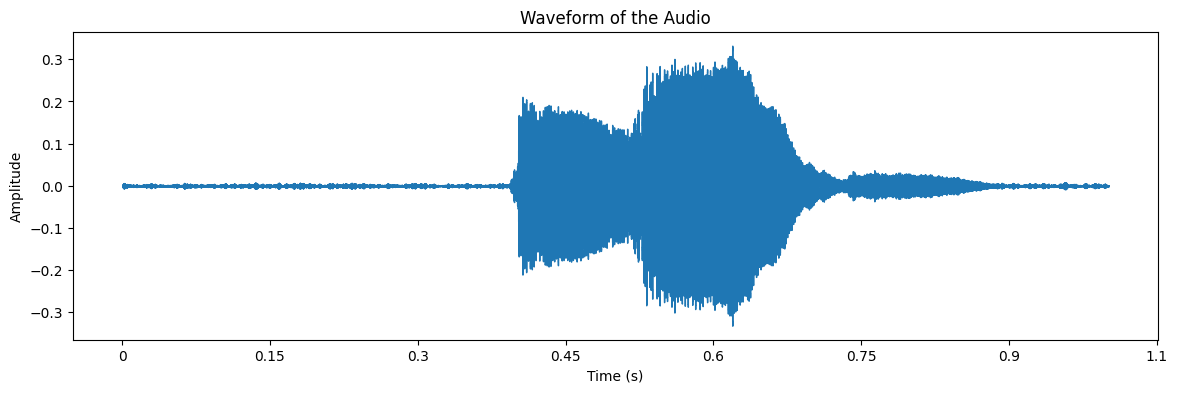

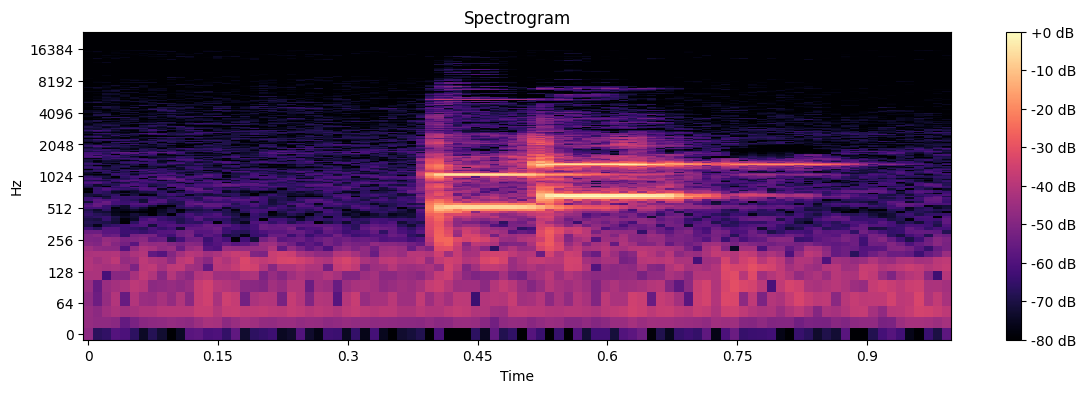

In [24]:
# Load the audio file
audio_path = 'input.m4a'  
y, sr = librosa.load(audio_path, sr=None)  
duration = len(y) / sr
print(f'Loaded audio file: {audio_path}\nSample Rate: {sr} Hz\nDuration: {duration:.2f} seconds')

# Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of the Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

# Compute and display spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(14, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

## 2. Detect Onsets (Event Segmentation)

We use Librosa’s onset detection to find the starting sample of each separate sound event. These onsets will be used to segment the audio.

Raw onsets: [0.032      0.40533333 0.53333333]
Filtered onsets: [0.40533333 0.53333333]


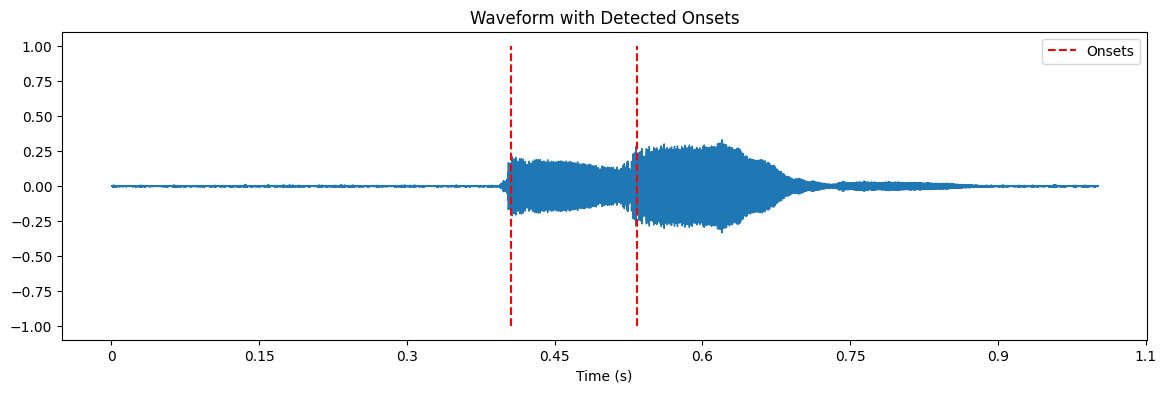

In [69]:
# Detect onsets in the audio (in sample indices)
raw_onsets = librosa.onset.onset_detect(y=y, sr=sr, units='samples')
# Convert to seconds for convenience
onset_times = raw_onsets / sr

# Filter out onsets that occur before 0.1 s (example threshold)
MIN_ONSET_TIME = 0.1
filtered_onsets = []
for onset_samp in raw_onsets:
    t_onset = onset_samp / sr
    # Check amplitude in a small window around the onset
    local_amp = np.max(np.abs(y[onset_samp:onset_samp+512])) if (onset_samp+512 < len(y)) else np.max(np.abs(y[onset_samp:]))
    # Example criteria: must be after 0.1s and local amplitude > 1% of max
    if (t_onset > MIN_ONSET_TIME) and (local_amp > 0.01 * np.max(np.abs(y))):
        filtered_onsets.append(onset_samp)

onset_samples = np.array(filtered_onsets)
onset_times = onset_samples / sr

print("Raw onsets:", raw_onsets / sr)
print("Filtered onsets:", onset_times)

# Plot the onsets on the waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr)
plt.vlines(onset_times, -1, 1, color='r', linestyle='--', label='Onsets')
plt.title('Waveform with Detected Onsets')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

## 3. Segment and Synthesize Each Event

For each detected event, we:

- Extract the event's segment from the original audio.
- Compute a smoothed envelope (using a simple moving average on the absolute value).
- Analyze the segment via FFT to estimate the fundamental frequency and additional harmonics.
- Synthesize the event via additive synthesis (summing sine waves at the fundamental and up to three harmonics, with amplitudes estimated from the FFT and modulated by the event envelope).

Finally, we place each synthesized event in its proper time slot to create a full synthesized signal.

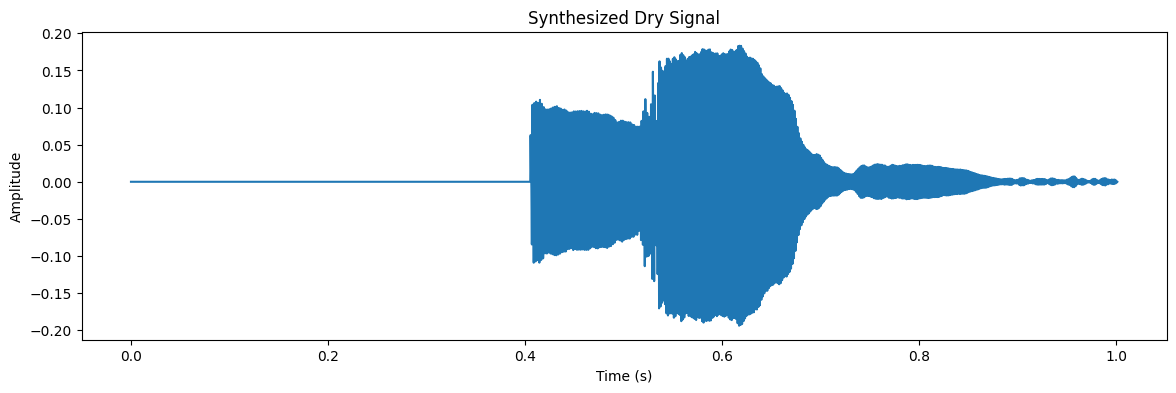

In [70]:
# Initialize an empty array for the final synthesized signal
synthesized = np.zeros_like(y)

# We'll define a function to find a stable fundamental and its harmonics
def analyze_and_synthesize(event_signal, sr):
    """
    Returns a synthesized version of event_signal
    using additive synthesis of fundamental + up to 4 harmonics.
    """
    N_event = len(event_signal)
    if N_event < 2:
        return np.zeros(N_event)

    # Envelope
    window_size = 256
    env = np.convolve(np.abs(event_signal), np.ones(window_size)/window_size, mode='same')

    # Basic FFT
    Y_event = np.abs(np.fft.rfft(event_signal))
    freqs_event = np.fft.rfftfreq(N_event, d=1/sr)

    # Find prominent peaks
    peaks_event, _ = find_peaks(Y_event, height=np.max(Y_event)*0.1, distance=10)
    if len(peaks_event) == 0:
        return np.zeros(N_event)

    # Sort by frequency to find the "lowest" peak -> treat as fundamental
    sorted_by_freq = sorted(peaks_event, key=lambda idx: freqs_event[idx])
    f0 = freqs_event[sorted_by_freq[0]]

    # Skip if fundamental < 50 Hz (or your chosen threshold)
    if f0 < 50:
        # Return silence if we consider it noise
        return np.zeros(N_event)

    # Optional: use a pitch detection approach, e.g.:
    # f0_est = librosa.yin(event_signal, fmin=50, fmax=2000, sr=sr)
    # pick median or mean over time, etc.

    # Let's gather up to 4 harmonics
    num_harmonics = 4
    harmonics_freq = [f0 * (n+1) for n in range(num_harmonics)]
    harmonics_amp = []

    for freq_h in harmonics_freq:
        # local search: find a small freq window near freq_h
        freq_window = 5  # +/- 5 Hz window
        # mask indices near freq_h
        mask = (freqs_event >= freq_h - freq_window) & (freqs_event <= freq_h + freq_window)
        if not np.any(mask):
            # no bins in that range
            harmonics_amp.append(0.0)
            continue
        # find the peak amplitude in that region
        subY = Y_event[mask]
        max_amp = np.max(subY)
        harmonics_amp.append(max_amp)

    # Normalize relative to fundamental
    if harmonics_amp[0] == 0:
        return np.zeros(N_event)
    norm_harmonics = [a / harmonics_amp[0] for a in harmonics_amp]

    # Synthesize
    t_event = np.linspace(0, N_event/sr, N_event, endpoint=False)
    synth_event = np.zeros(N_event)
    for i, hfreq in enumerate(harmonics_freq):
        synth_event += norm_harmonics[i] * env * np.sin(2*np.pi*hfreq * t_event)

    return synth_event

# Loop over events
for i in range(len(onset_samples)):
    start = onset_samples[i]
    end = onset_samples[i+1] if i < len(onset_samples)-1 else len(y)
    event_signal = y[start:end]
    synth_event = analyze_and_synthesize(event_signal, sr)
    synthesized[start:end] += synth_event

# Plot the synthesized (dry) signal
t_full = np.linspace(0, duration, len(synthesized), endpoint=False)
plt.figure(figsize=(14, 4))
plt.plot(t_full, synthesized)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synthesized Dry Signal')
plt.show()

## 3.1 Listen Dry Synthesis

For debugging, let's skip reverb to see if we still get the extra event or low-frequency noise. Re-introduce reverb later if desired.

Playing synthesized sound (dry, no reverb)...


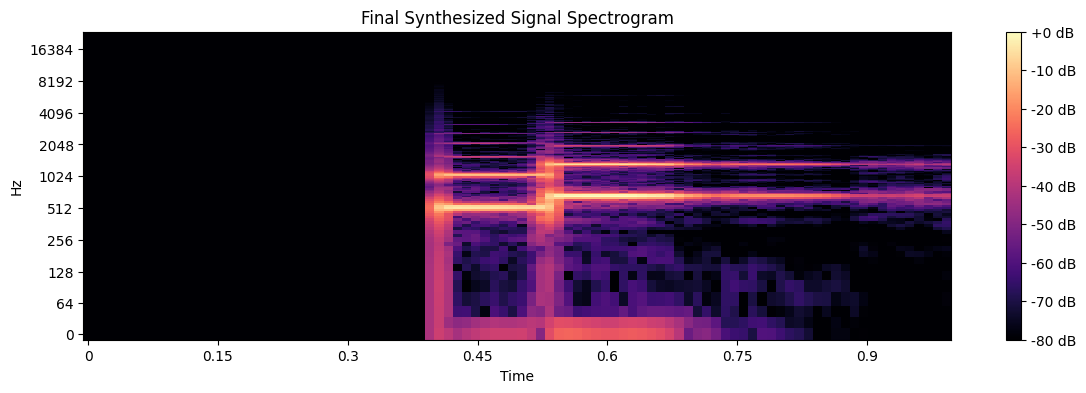

Saved filtered_synthesized.wav


In [82]:
# Normalize
max_val = np.max(np.abs(synthesized))
if max_val > 0:
    synthesized /= max_val

print('Playing synthesized sound (dry, no reverb)...')
sd.play(synthesized, sr)
sd.wait()

# Compute and display spectrogram of the new signal
D = librosa.amplitude_to_db(np.abs(librosa.stft(synthesized)), ref=np.max)
plt.figure(figsize=(14, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Final Synthesized Signal Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

# Save
sf.write('filtered_synthesized.wav', synthesized, sr)
print('Saved filtered_synthesized.wav')

## 4. Apply a Convolution-Based Reverb

We simulate a reverb effect by convolving the dry synthesized signal with a synthetic impulse response. Here an exponential decay impulse response is used.

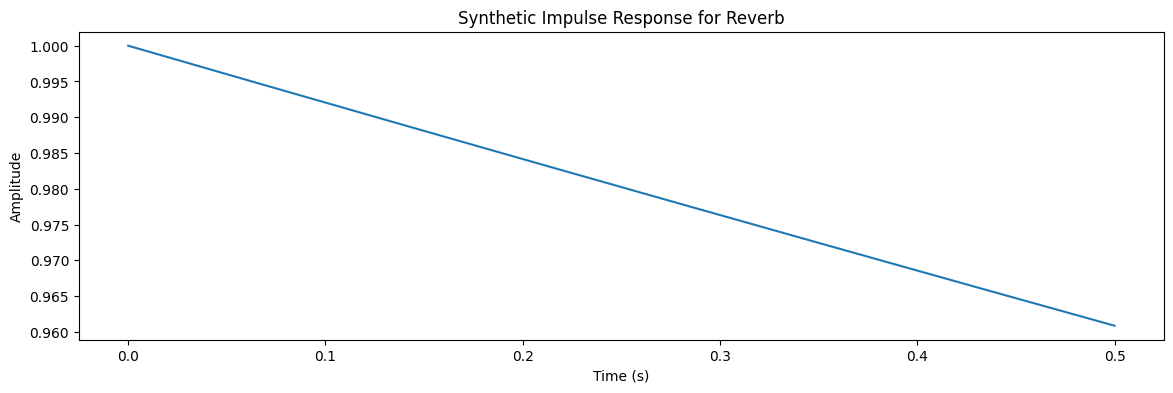

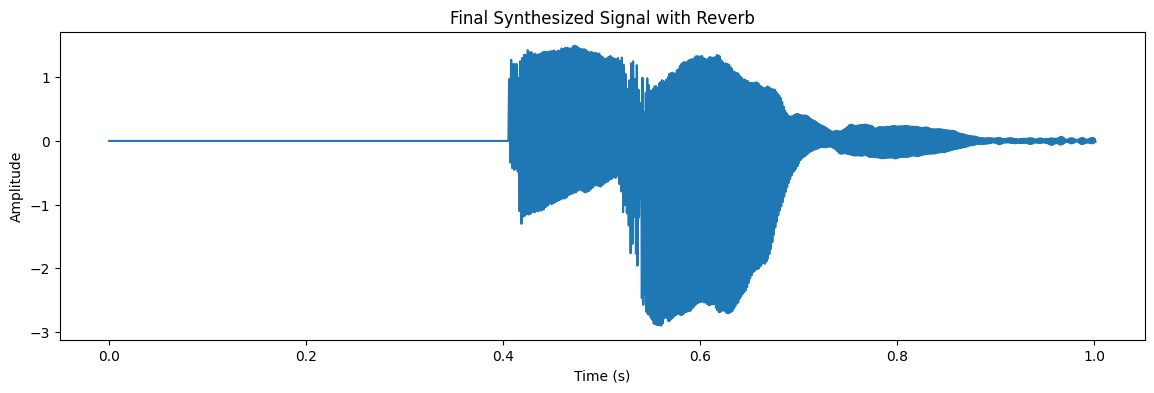

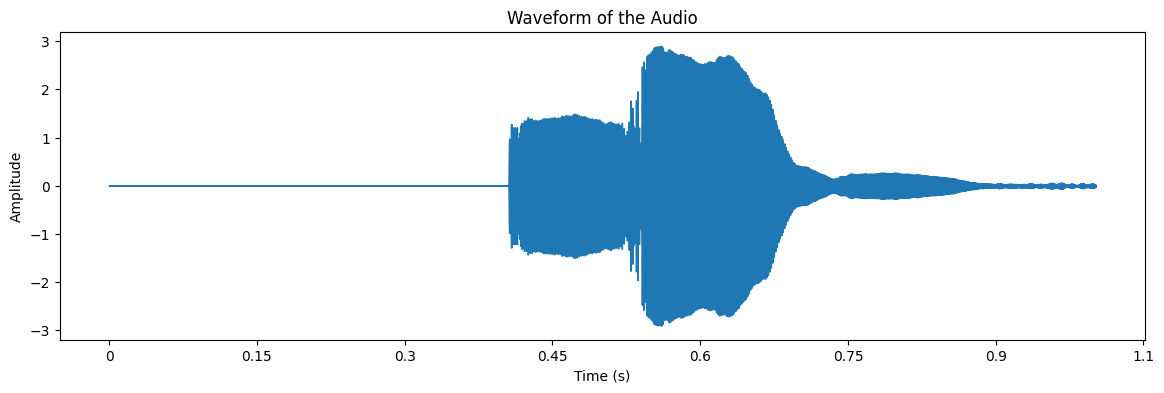

In [110]:
def create_impulse_response(sr, ir_duration=0.5, decay=3.0):
    t_ir = np.linspace(0, ir_duration, int(sr * ir_duration), endpoint=False)
    ir = np.exp(-decay * t_ir)  # exponential decay
    ir /= np.max(ir)            # normalize
    return ir

# Generate the impulse response
ir = create_impulse_response(sr, ir_duration=0.01, decay=4.0)

# Plot the impulse response
plt.figure(figsize=(14, 4))
plt.plot(np.linspace(0, 0.5, len(ir)), ir)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synthetic Impulse Response for Reverb')
plt.show()

# Apply convolution-based reverb (using FFT-based convolution)
wet_signal = fftconvolve(synthesized, ir, mode='full')
wet_signal = wet_signal[:len(synthesized)]  # Trim to original length

# Mix dry and wet signals
final_signal = 0.7 * wet_signal + 0.3 * synthesized

plt.figure(figsize=(14, 4))
plt.plot(t_full, final_signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Final Synthesized Signal with Reverb')
plt.show()

# Plot new signal
plt.figure(figsize=(14, 4))
librosa.display.waveshow(final_signal, sr=sr)
plt.title('Waveform of the Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## 5. Playback and Save the Final Synthesized Sound

We use `sounddevice` to play the final signal and `soundfile` to save it as a WAV file.

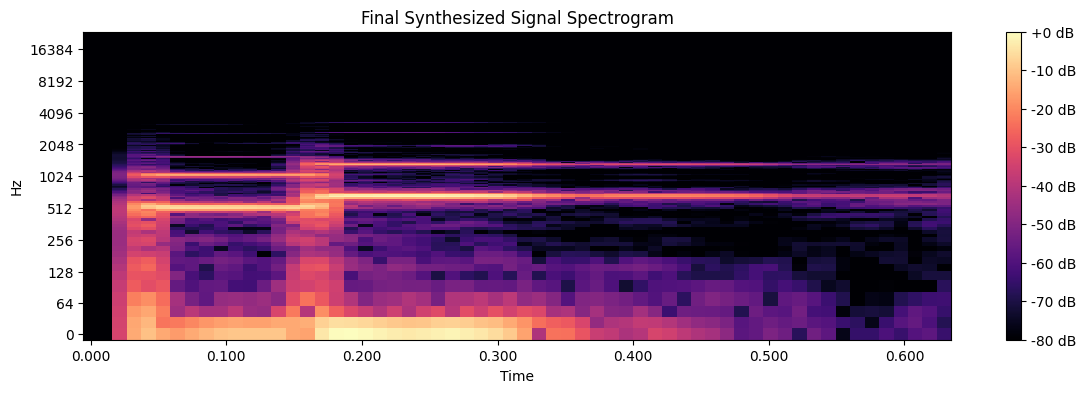

Playing the final synthesized sound...
Final synthesized sound saved to advanced_synthesized_sound.wav


In [111]:
# Normalize to prevent clipping
max_val = np.max(np.abs(final_signal))
if max_val > 0:
    final_signal = final_signal / max_val

# Delete the initial silence
final_signal = final_signal[int(sr * 0.37):]

# Compute and display spectrogram of the new signal
D = librosa.amplitude_to_db(np.abs(librosa.stft(final_signal)), ref=np.max)
plt.figure(figsize=(14, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Final Synthesized Signal Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

print('Playing the final synthesized sound...')
sd.play(final_signal, sr)
sd.wait()

# Save to file
output_file = 'advanced_synthesized_sound.wav'
sf.write(output_file, final_signal, sr)
print(f'Final synthesized sound saved to {output_file}')